In [1]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../'))
from collections import defaultdict
import glob
import librosa
from tqdm import tqdm
import numpy as np
import librosa.display
import moviepy.editor as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from sklearn.preprocessing import minmax_scale
import csv

In [2]:
AUDIO_DIR = f"{os.path.abspath('./../../')}/eNTERFACE05_Dataset/*/*/*/*.avi"
CONFIG_FILE = f"{os.path.abspath('./../../')}/Audio_Sentiment_Analysis/data/config.json"

In [3]:
config = Configuration.load_json(CONFIG_FILE)

In [26]:
def extract_features(audio_file, subject, emotion):
    y, sr = librosa.load(audio_file, res_type='kaiser_fast')

    rms = librosa.feature.rms(y)
    chroma_stft = librosa.feature.chroma_stft(y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y, sr=sr)
    mel_spect = librosa.feature.melspectrogram(y, sr=sr, n_mels=config.n_mels)

    features_str = f'{subject} {emotion} {np.mean(mel_spect)} {np.min(mel_spect)} {np.max(mel_spect)} {np.var(mel_spect)} {np.std(mel_spect)}\
        {np.mean(chroma_stft)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'

    for e in mfcc:
        features_str += f' {np.mean(e)}'

    return features_str.split()

In [27]:
def process_data(audio_dir, proc_feat_dataset):
    # Create a CSV for storing all processed features and write the header
    header = 'subject emotion mel_mean mel_min mel_max mel_var mel_std chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header = header.split()
    file = open(proc_feat_dataset, 'w', newline='')
    writer = csv.writer(file)
    writer.writerow(header)

    print("Processing audio files from all subjects:")
    for file_path in tqdm(glob.glob(audio_dir)):
        labels =  file_path.split('\\')
        # labels =  file_path.split('/')
        subject = labels[-4].split()[1]
        emotion = labels[-3]
        file_type = labels[-1].split('.')[-1]

        if file_type == 'avi':
            audio_file_path = file_path[:-3] + 'wav'
            # convert file type to wav
            if not os.path.isfile(audio_file_path):
                audio_clip = mp.VideoFileClip(file_path)
                audio_clip.audio.write_audiofile(audio_file_path)
            file_path = audio_file_path

        processed_data = extract_features(file_path, subject, emotion)
        writer.writerow(processed_data)
            

In [28]:
# extract features from audio files and store them in a dataset
proc_feat_dataset = 'proc_feat_ent05.csv'
process_data(AUDIO_DIR, proc_feat_dataset)

Processing audio files from all subjects:


100%|██████████| 1287/1287 [00:57<00:00, 22.46it/s]


In [37]:
def load_data(proc_feat_dataset):
    sub_emo_data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

    with open(proc_feat_dataset) as dataset:
        reader = csv.DictReader(dataset)
        for row in reader:
            subject, emotion = row.pop('subject'), row.pop('emotion')
            sub_emo_data[subject][emotion]['features'].append(list(row.values()))
    return sub_emo_data

In [38]:
# Load the processed features writen in the dataset
# sub_emo_data = { subject: { emotion: { files: [], features: [] } } }
sub_emo_data = load_data(proc_feat_dataset)

In [41]:
def display_melspecgram(mel_fig, axs, i, emotion, melspecgram):
    ax = axs[0 if i < 3 else 1, i if i < 3 else i - 3]
    im = ax.pcolormesh(melspecgram, cmap="magma")
    ax.set_title(emotion)
    mel_fig.colorbar(im, ax=ax)

In [89]:
def analyse_features(sub_emo_data):
    # { emotion : { zero_cr: [], spec_cent } }
    emo_data = defaultdict(lambda: defaultdict(list))

    for subject, sub_data in sub_emo_data.items():
        for emotion in sub_data:
            # mel_mean mel_min mel_max mel_var mel_std chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate
            features = np.array(sub_data[emotion]['features'])

            emo_data[emotion]['mel_mean'].extend(features[:,0])
            emo_data[emotion]['mel_min'].extend(features[:,1])
            emo_data[emotion]['mel_max'].extend(features[:,2])
            emo_data[emotion]['mel_var'].extend(features[:,3])
            emo_data[emotion]['mel_std'].extend(features[:,4])
            emo_data[emotion]['chroma_stft'].extend(features[:,5])
            emo_data[emotion]['rmse'].extend(features[:,6])
            emo_data[emotion]['spec_cent'].extend(features[:,7])
            emo_data[emotion]['spec_band'].extend(features[:,8])
            emo_data[emotion]['rolloff'].extend(features[:,9])
            emo_data[emotion]['zero_cr'].extend(features[:,10])

    spec_cent, zero_cr = [], []
    for emotion, features in emo_data.items():
        # scaling features between 0 and 1
        zero_cr_values = minmax_scale(features['zero_cr'], config.scale_range)
        spec_cent_values = minmax_scale(features['spec_cent'], config.scale_range)

        # obtain mean and store it
        zero_cr.append(np.mean(zero_cr_values))
        spec_cent.append(np.mean(spec_cent_values))


    df = pd.DataFrame(zip(list(emo_data.keys())*6, ["Zero Crossing Rate"]*6+["Spectral Centroid"]*6,\
        zero_cr+spec_cent), columns=["Emotion", "Mean Values", 'Value'])
    plt.figure(figsize=(10, 6))
    plt.title("Emotions' Features of All Subjects")
    sns.barplot(x="Emotion", hue="Mean Values", y="Value", data=df)
    plt.show()

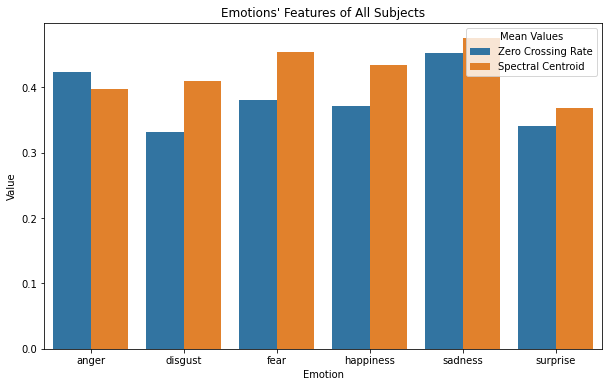

In [90]:
# analyse the extracted features
analyse_features(sub_emo_data)

In [ ]:
# subject emotion mel_mean mel_min mel_max mel_var mel_std chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate


